# t-digests

## Introduction

* T-digests are a refinement on Q-digests. It adapts them to the streaming setting.
* The problem with Q-digests is that they require the possible values be known in advance, which limits the maximum granularity of observations (and bins).
* T-digests have three interesting algorithmic features.
* First, the ranges of data included in bins may overlap.
* Second, bins are summarized by a centroid value and an accumulated weight representing the number of samples contributing to the bin.
* Third, samples are accumulated such that only a few may contribute to bins corresponding with extreme quantiles. This results in bounded quantile estimation error instead of constant error.
* More specifically, the t-digests is constructed in such a way that the error for quantile $q$ is constant relative to $q(1-q)$. Thus quantiles that are further towards the edges of the distribution are more accurately recorded. This is good for streaming purposes!
* There are two competing t-digest algorithmic implementations. One is a buffer-and-merge algorithm, the other is a cluster-based algorithm. There are some tradeoffs in choosing one or the other.

## Conceptual description

* Suppose ordered samples $X = x_1,\ldots,x_n$. Group the sequence into subsequences $X = \{s_1 | s_2 | \ldots | s_m\}$, where $s_i = \{x_{\text{left}(i)}, x_{\text{right}(i)}\}$.
* As an aside, we allow subsequences near the ends to be small, and subsequences near the middle to be large.
* Define a t-digest scaling function $k(q, \delta)$ which maps every quantile $q$ to a notional index $k$, subject to compression parameter $\delta$.
* A t-digest scaling function is valid so long as it is monotonic increasing and maps the domain $[0, 1]$ to range $[0, \delta]$.
* To get the scaling properties we want we choose the following scaling function:

$$k(q, \delta) = \delta \times \left(\frac{sin^{-1}(2q - 1)}{\pi} + \frac{1}{2}\right)$$

* The $k$-size of subsequence $i$ ($s_i$), $K(i)$, is the distance between its minimum and maximum value when k-transformed. We require this to be less than 1. Formally:

$$K(i) = k(\text{right}(i)/n, \delta) - k((\text{left}(i) - 1)/n, \delta) \leq 1$$

* Furthermore, we require that adjacent subsequences be of a $k$-size of at least 1:

$$\forall i \in \{1,\ldots,m-1\}. \: K(i) + K(i + 1) > 1$$

* This first condition is an upper bound on the size of any particular subsequence, and this second condition is a lower bound.
* Why do we need this transform? The larger the distance between two quantiles in the transformed space, the harder it will be to construct large subsequences in that space that satisfy these two conditions. Here is the space that we get when we run the quantiles through the scaling function:

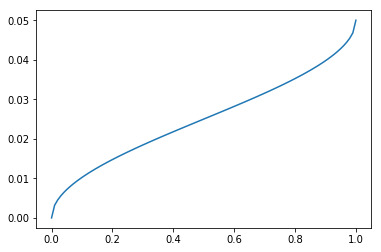

In [11]:
import numpy as np

def t_digest_scaling_function(q, δ):
    return δ * ((np.arcsin(2 * q - 1) / np.pi) + 1 / 2)

import matplotlib.pyplot as plt
qrange = np.linspace(0, 1, 100)

plt.plot(qrange, [t_digest_scaling_function(q, 0.05) for q in qrange])

* Notice how the resultant space covers much more distance at the far edges of the graph. Subsequences that satisfy the two invariants will be much smaller here than through the rest of the graph, as fewer samples will cover more distance.
* Thus the net effect of these invariants is that the subsequences on the edges, near the .9 and .99 and so on quantile range, where we desire to be most accurate, will be far smaller than those through the rest of the graph!
* Down the line that'll correspond with non-linear compression; everything in the middle will be much more compressed than things on the edges.
* Once we have formed these subspaces, all that remains is doing some interpolation on the bin of interest to get a percentile estimate result.

## Buffered algorithm

Now we can work on the implementation.

In [143]:
class TDigest():
    def __init__(self, δ, X=None):
        self.centroids = merge([], X).centroids if X else []
        self.δ = δ
        
    def insert(self, X):
        self.centroids = merge(self.centroids, X)
        
    # TODO: debug this algo.
    def quantile(self, x):
        t = 0
        N = sum([c.count for c in self.centroids])
        m = len(self.centroids)
        C = self.centroids
        
        for i in range(0, m - 1):            
            C_bar = C[i].mean()
            
            if i < m - 1:
                Δ = (C[i + 1].mean() - C_bar) / 2
            else:
                Δ = (C_bar - C[i - 1].mean()) / 2
                
            z = max(-1, (x - C_bar) / Δ)
            k_i = C[i].count
            if z < 1:
                return t / N + k_i / N * (z + 1) / 2
            else:
                t = t + k_i
        
        
class Centroid():
    def __init__(self, sum, count):
        self.sum = sum
        self.count = count
    
    def mean(self):
        return self.sum / self.count
        
    def __str__(self):
        return "Centroid(sum={0}, count={1})".format(self.sum, self.count)

    
def merge(digest, X):
    """
    Merges the given buffer of new data X into the given digest. Returns a new object.
    """
    # Special case: empty observations list.
    if not X:
        return digest
    
    X = sort(digest.centroids, X)
    S = sum([x.count for x in X])
    C_p = []
    q_0 = 0
    _q_limit = q_limit(q_0, digest.δ)
    σ = X[0]
    m = len(digest.centroids)
    n = len(X)
    
    for i in range(1, m + n):  # zero-offset; paper is one-offset
        x_i = X[i]
        q = q_0 + (σ.count + x_i.count) / S

#         print(q, _q_limit)
#         import pdb; pdb.set_trace()
        if q <= _q_limit:
            σ = Centroid(σ.sum + x_i.sum, σ.count + x_i.count)
            
        else:
            C_p.append(σ)
            q_0 = q_0 + σ.count / S
            _q_limit = q_limit(q_0, digest.δ)
            σ = x_i
            
    # As a special case, the last value is always inserted.
    C_p.append(σ)
    
    digest = TDigest(digest.δ)
    digest.centroids = C_p
    return digest
        

def sort(centroids, X):
    """
    Sorts a list of observations X into and with a list of centroids with components sum and count.
    
    Helper function for merge.
    """
    # Special case: empty digest.
    if not X:
        return centroids
    
    # Special case: empty observations list.
    # Pre-populate first entry to prevent index out of bounds errors.
    if not centroids:
        centroids = [Centroid(X[0], 1)]
        X = X[1:]
    
    c_i = 0
    for x in sorted(X):
        while True:
            if x < centroids[c_i].sum / centroids[c_i].count:
                centroids.insert(c_i, Centroid(x, 1))
                break
            else:
#             elif x > centroids[c_i].sum / centroids[c_i].count:
                if c_i < len(centroids) - 1:
                    c_i += 1
                else:
                    centroids.append(Centroid(x, 1))
                    break
#             else:  # ==
#                 c = centroids[c_i]
#                 c.sum += x
#                 c.count += 1
#                 break
    return centroids

def k(q, δ):
    """t-digest scaling function. Helper function."""
    return δ * ((np.arcsin(2 * q - 1) / np.pi) + 1 / 2)

def k_inv(q_trans, δ):
    """t-digest scaling function inverse. Helper function."""    
    return (np.sin(np.pi * (q_trans / δ - 1 / 2)) + 1) / 2

def q_limit(q, δ):
    """
    For the given quantile q and scaling factor δ, returns the maximum quantile q_limit 
    such that [q, q_limit] < 1, as per the invariant.
    Helper function. Uses k and k_inv, defined above.
    """
    return k_inv(k(q, δ) + 1, δ)

In [64]:
# Sorting tests.

r = sort([Centroid(0, 1), Centroid(1, 1)], [0, 1])
print([str(_) for _ in r])

r = sort([Centroid(0, 1), Centroid(1, 1)], [0, 0, 1, 1])
print([str(_) for _ in r])

r = sort([Centroid(0, 1), Centroid(1, 1)], [2])
print([str(_) for _ in r])

r = sort([Centroid(0, 1), Centroid(1, 1)], [2, 2])
print([str(_) for _ in r])

r = sort([Centroid(0, 1), Centroid(1, 1)], [0, 1, 2, 3])
print([str(_) for _ in r])

r = sort([], [0])
print([str(_) for _ in r])

r = sort([Centroid(0, 1)], [])
print([str(_) for _ in r])

r = sort([], [])
print([str(_) for _ in r])

['Centroid(sum=0, count=1)', 'Centroid(sum=0, count=1)', 'Centroid(sum=1, count=1)', 'Centroid(sum=1, count=1)']
['Centroid(sum=0, count=1)', 'Centroid(sum=0, count=1)', 'Centroid(sum=0, count=1)', 'Centroid(sum=1, count=1)', 'Centroid(sum=1, count=1)', 'Centroid(sum=1, count=1)']
['Centroid(sum=0, count=1)', 'Centroid(sum=1, count=1)', 'Centroid(sum=2, count=1)']
['Centroid(sum=0, count=1)', 'Centroid(sum=1, count=1)', 'Centroid(sum=2, count=1)', 'Centroid(sum=2, count=1)']
['Centroid(sum=0, count=1)', 'Centroid(sum=0, count=1)', 'Centroid(sum=1, count=1)', 'Centroid(sum=1, count=1)', 'Centroid(sum=2, count=1)', 'Centroid(sum=3, count=1)']
['Centroid(sum=0, count=1)']
['Centroid(sum=0, count=1)']
[]


The below proves that it works!

In [144]:
r = merge(TDigest(δ=0.8), [1, 2, 3, 4, 5])
[str(_) for _ in r.centroids]

['Centroid(sum=10, count=4)', 'Centroid(sum=5, count=1)']

In [150]:
r = merge(TDigest(δ=0.1), [1, 2, 3, 4, 5])
[str(_) for _ in r.centroids]

['Centroid(sum=1, count=1)',
 'Centroid(sum=2, count=1)',
 'Centroid(sum=3, count=1)',
 'Centroid(sum=4, count=1)',
 'Centroid(sum=5, count=1)']

In [165]:
r.quantile(0.9)

0.08000000000000002

* Need some notes on how the quantile function works.
* Need to debug the quantile function.
* There's also an aforementioned clustering approach to this algorithm, which is not all that different. I will not go into it or implement it here.